# 1. Introdução do Notebook

# 2. Carregar bibliotecas

In [2]:
import os
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          DataCollatorForTokenClassification, TrainingArguments, Trainer)

# 3. Carregar dataset (HuggingFace)

In [3]:
dataset_id = "peluz/lener_br"

# Tenta pegar o token da variável de ambiente
hf_token = os.getenv("HF_TOKEN")

lener = load_dataset(dataset_id, token=hf_token)
lener

c:\Users\diogo\Repositorios\ner_smalllm_project\.venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for peluz/lener_br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/peluz/lener_br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})

In [4]:
print(lener["train"][0])

{'id': '0', 'tokens': ['EMENTA', ':', 'APELAÇÃO', 'CÍVEL', '-', 'AÇÃO', 'DE', 'INDENIZAÇÃO', 'POR', 'DANOS', 'MORAIS', '-', 'PRELIMINAR', '-', 'ARGUIDA', 'PELO', 'MINISTÉRIO', 'PÚBLICO', 'EM', 'GRAU', 'RECURSAL', '-', 'NULIDADE', '-', 'AUSÊNCIA', 'DE', 'INTERVENÇÃO', 'DO', 'PARQUET', 'NA', 'INSTÂNCIA', 'A', 'QUO', '-', 'PRESENÇA', 'DE', 'INCAPAZ', '-', 'PREJUÍZO', 'EXISTENTE', '-', 'PRELIMINAR', 'ACOLHIDA', '-', 'NULIDADE', 'RECONHECIDA', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Média de tokens por sentença: 29.29
Tamanho da maior sentença: 755


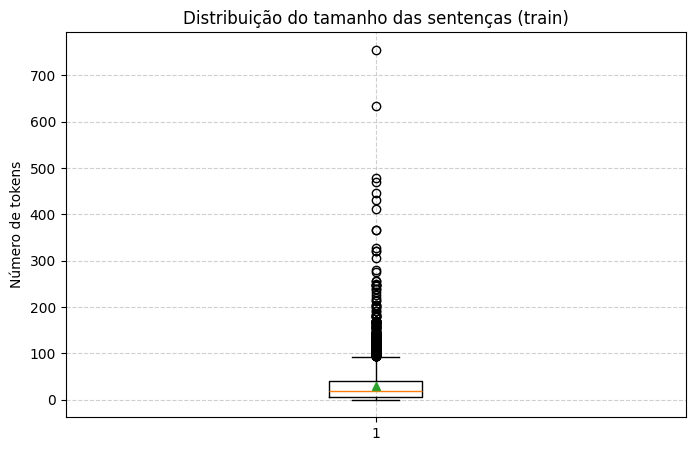

In [5]:
# Extrai o tamanho de cada sentença do conjunto de treino
sizes = [len(sample["tokens"]) for sample in lener["train"]]

# Estatísticas básicas
avg_len = sum(sizes) / len(sizes)
max_len = max(sizes)

print(f"Média de tokens por sentença: {avg_len:.2f}")
print(f"Tamanho da maior sentença: {max_len}")

# Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(sizes, vert=True, showmeans=True)
plt.title("Distribuição do tamanho das sentenças (train)")
plt.ylabel("Número de tokens")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
ner_feature = lener["train"].features["ner_tags"]
label_list = ner_feature.feature.names  # lista dos rótulos
num_labels = len(label_list)
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}
label_list, num_labels

# 4. Preparar tokenizer

In [ ]:
checkpoint = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

MAX_LEN = 256


def tokenize_and_align(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LEN,
    )

    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_word = None
        label_ids = []
        for w_id in word_ids:
            if w_id is None:
                label_ids.append(-100)
            elif w_id != prev_word:
                label_ids.append(labels[w_id])
            else:
                # subtoken: aqui você está replicando o mesmo label no subtoken
                label_ids.append(labels[w_id])
            prev_word = w_id
        all_labels.append(label_ids)

    tokenized["labels"] = all_labels
    return tokenized


tokenized_ds = lener.map(
    tokenize_and_align,
    batched=True,
    remove_columns=["tokens", "ner_tags", "id"],  # opcional
)

print(tokenized_ds["train"][0].keys())

Map:   0%|          | 0/7828 [00:00<?, ? examples/s]

Map:   0%|          | 0/1177 [00:00<?, ? examples/s]

Map:   0%|          | 0/1390 [00:00<?, ? examples/s]

# 5. Preparar dataloader

# 6. Configurar o modelo

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_labels = []
    true_preds = []

    for pred, lab in zip(predictions, labels):
        cur_labels = []
        cur_preds = []
        for p_i, l_i in zip(pred, lab):
            if l_i == -100:
                continue
            cur_labels.append(label_list[l_i])
            cur_preds.append(label_list[p_i])
        true_labels.append(cur_labels)
        true_preds.append(cur_preds)

    results = metric.compute(predictions=true_preds, references=true_labels)
    # Pega F1 global (ou macro, etc.)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 7. Treino inicial

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="results_lenerbr",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=3,  # pra Entrega 1, 2 épocas já bastam
    per_device_train_batch_size=8,  # se esquentar, baixa pra 4
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    fp16=True,  # usa half precision na GPU
    report_to="none",  # evita logs no wandb, etc.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics_val = trainer.evaluate()
metrics_val

C:\Users\diogo\AppData\Local\Temp\ipykernel_17688\2734986473.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.075700,nan,0.839255,0.856114,0.847601,0.969023
2,0.030500,nan,0.802391,0.908734,0.852258,0.971064
3,0.016500,nan,0.873258,0.889083,0.881099,0.976536


{'eval_loss': nan,
 'eval_precision': 0.8732575595110444,
 'eval_recall': 0.8890829694323145,
 'eval_f1': 0.8810992102131343,
 'eval_accuracy': 0.9765356910996383,
 'eval_runtime': 6.1649,
 'eval_samples_per_second': 190.92,
 'eval_steps_per_second': 24.007,
 'epoch': 3.0}

In [12]:
# Caminho onde você quer guardar o modelo final
save_dir = "models/lenerbr_bert_base"

# Salva o modelo (pesos + config)
trainer.save_model(save_dir)

# Salva o tokenizer também (importantíssimo!)
tokenizer.save_pretrained(save_dir)

print(f"Modelo e tokenizer salvos em: {save_dir}")

Modelo e tokenizer salvos em: models/lenerbr_bert_base


# 8. Avaliação parcial (F1)

# 9. Predições de exemplo

In [13]:
example = lener["test"][0]
tokens = example["tokens"]

# Faz o encode com word_ids para alinhar sub-tokens a palavras
encoding = tokenizer(
    tokens,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True,
)

word_ids = encoding.word_ids()

# Envia para GPU (se disponível)
device = "cuda" if torch.cuda.is_available() else "cpu"
encoding = {k: v.to(device) for k, v in encoding.items()}
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(**encoding)

pred_ids = outputs.logits.argmax(-1).cpu().numpy()[0]

pred_labels = []
clean_tokens = []
used = set()

for idx, w_id in enumerate(word_ids):
    if w_id is None:
        continue
    if w_id in used:
        continue
    used.add(w_id)
    clean_tokens.append(tokens[w_id])
    pred_labels.append(label_list[pred_ids[idx]])

list(zip(clean_tokens, pred_labels))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[('Número', 'O'),
 ('do', 'O'),
 ('Acórdão', 'O'),
 ('ACÓRDÃO', 'B-JURISPRUDENCIA'),
 ('1160/2016', 'I-JURISPRUDENCIA'),
 ('-', 'O'),
 ('PLENÁRIO', 'B-ORGANIZACAO'),
 ('Relator', 'O'),
 ('AUGUSTO', 'B-PESSOA'),
 ('NARDES', 'I-PESSOA'),
 ('Processo', 'B-JURISPRUDENCIA'),
 ('006.010/2000-4', 'I-JURISPRUDENCIA'),
 ('Tipo', 'O'),
 ('de', 'O'),
 ('processo', 'O'),
 ('TOMADA', 'O'),
 ('DE', 'O'),
 ('CONTAS', 'O'),
 ('SIMPLIFICADA', 'O'),
 ('(', 'O'),
 ('TCSP', 'O'),
 (')', 'O'),
 ('Data', 'O'),
 ('da', 'O'),
 ('sessão', 'O'),
 ('11/05/2016', 'B-TEMPO'),
 ('Número', 'O'),
 ('da', 'O'),
 ('ata', 'O'),
 ('16/2016', 'O'),
 ('Relator', 'O'),
 ('da', 'O'),
 ('deliberação', 'O'),
 ('recorrida', 'O'),
 ('Ministra', 'O'),
 ('Ana', 'B-PESSOA'),
 ('Arraes', 'I-PESSOA'),
 ('.', 'O')]

# 10 Salvar gráficos e métricas